In [92]:
#import requests
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import urllib.parse
import json
import pickle
import requests
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
import sys
sys.path.append(os.path.abspath(".."))
from src.utils import plot_neighbors
from src.utils import plot_pca

ImportError: cannot import name 'plot_pca' from 'src.utils' (/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/canon-paintings-smk/src/utils.py)

In [2]:
# read df from csv 
data_path = os.path.join('..', 'data')
df = pd.read_pickle(os.path.join(data_path, 'all_paintings_subset.pkl'))

In [3]:
# load image data
json_path = os.path.join(data_path, 'all_paintings_metadata')

# Open and read the JSON file
with open(json_path, 'r') as file:
    metadata = json.load(file)

In [4]:
ds = load_dataset("louisebrix/smk_all_paintings", split="train")

In [5]:
df['rgb'] = ds['rgb'] 

In [7]:
def extract_canon_info(item):

    ''''
    Get information on canon features from smk item
    '''

    content_keys = ['exhibitions',
                    'acquisition_date', 
                    'responsible_department', 
                    'documentation', 
                    'on_display', 
                    'current_location_name',
                    'literary_reference',
                    'object_history_note']

    content_data = {field: item.get(field, pd.NA) for field in content_keys}

    return content_data

In [8]:
data_dicts = []
for item in tqdm(metadata, total=len(metadata)):
    content_data = extract_canon_info(item)
    data_dicts.append(content_data)

data_df = pd.DataFrame(data_dicts)
df = pd.concat([df, data_df], axis=1)     

100%|██████████| 2085/2085 [00:00<00:00, 151901.54it/s]


In [12]:
# get exhibition venues to check how many are from smk
def exhb_venues(exhb_dict):
    
    if exhb_dict is not pd.NA:
        venues = []
        for i in range(len(exhb_dict)):
            venue = exhb_dict[i].get('venue', pd.NA)
            venues.append(venue)
        return venues
    
    else:
        return pd.NA

In [14]:
venues_list = [exhb_venues(exhb_dict) for exhb_dict in df['exhibitions']]
df['exhibition_venues'] = venues_list

In [15]:
df.query('on_display == True')['nationality'].explode().value_counts()

nationality
Dansk        189
Norsk         14
Tysk           8
Fransk         7
Italiensk      5
Svensk         3
Engelsk        1
Britisk        1
Name: count, dtype: int64

In [16]:
def extract_enrichment_wiki_info(smk_id, session):

    '''
    Make calls to enrichment API and relevant extract information
    '''
    try:
        try:
            # enrichment API can't handle slashes in the smk_id as it sees them as part of the path, so they need to be encoded properly
            encoded_smk_id = urllib.parse.quote(smk_id, safe='')
            enrichment_url = f'https://enrichment.api.smk.dk/api/enrichment/{encoded_smk_id}'
            enrichment_request = session.get(enrichment_url)
            enrichment_json = enrichment_request.json()
        
        except Exception:
            # SMK API is case insensitive but Enrichment API is not, so try to make the smk_id uppercase in case this is why the request fails
            uppercase_smk_id = smk_id.upper()
            encoded_smk_id = urllib.parse.quote(uppercase_smk_id, safe='')
            enrichment_url = f'https://enrichment.api.smk.dk/api/enrichment/{encoded_smk_id}'
            enrichment_request = session.get(enrichment_url)
            enrichment_json = enrichment_request.json()

        wiki_data = pd.NA
        for item in enrichment_json:
            if item.get('type') == 'wikidata':
                
                wiki_data = item.get('data', pd.NA).get('wikidata_link_da_s', pd.NA)
                
                break

    # if request still fails, print error message and append NA for this object
    except Exception as e:
        #print(f"Error fetching enrichment API data: {enrichment_url}")
        return pd.NA

    return wiki_data

In [ ]:
# not sure we need this (and code takes some time to run)
#wiki_data_list = [extract_enrichment_wiki_info(smk_id, session) for smk_id in df['smk_id']]
#df['wiki_data'] = wiki_data_list
#df[~df['wiki_data'].isna()]

If a painting has been in an exhibition at SMK it will be under 'Sølvgade' (the adress for SMK) in 'venues'

In [17]:
def check_smk(venues):
    if isinstance(venues, list):
        if any(isinstance(v, str) and 'Sølvgade' in v for v in venues):
            return True 
        else:
            return False 
    else:
        return False

In [19]:
smk_exhibitions = [check_smk(venues) for venues in df['exhibition_venues']]
df['smk_exhibitions'] = smk_exhibitions

In [20]:
df.query('smk_exhibitions == True')

,smk_id,period,start_year,title,first_artist,all_artists,num_artists,main_type,all_types,image_thumbnail,...,exhibitions,acquisition_date,responsible_department,documentation,on_display,current_location_name,literary_reference,object_history_note,exhibition_venues,smk_exhibitions
27,KMS8884,1835,1835,Parti af torvet i Amalfi,Martinus Rørbye,[Martinus Rørbye],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/tt44ps41w_km...,...,"[{'exhibition': '""Danish Golden Age"" Petit Pal...",2018-11-27T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,<NA>,True,Sal 219,<NA>,<NA>,"[Petit Palais, Sølvgade, Nationalmuseum, Stock...",True
29,KMS3880,1800,1800,Jurisprudensen. Allegorisk figur,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/mw22v869s_KM...,...,[{'exhibition': 'Nicolai Abildgaard - Kroppen ...,1930-01-01T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,[{'title': 'Fortegnelse over den danske Samlin...,False,<NA>,<NA>,[På auktion efter Abildgaards enke solgt til J...,"[Louvre, Hamburger Kunsthalle, Sølvgade, Nasjo...",True
30,KMS7591,1800,1800,Filosofien,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/3x816q91r_KM...,...,[{'exhibition': 'Nicolai Abildgaard - Kroppen ...,1991-01-01T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,[{'title': 'Abildgaard=abildgård: kunstneren m...,False,<NA>,<NA>,<NA>,"[Louvre, Hamburger Kunsthalle, Sølvgade, Det K...",True
32,KMS6557,1750,1750,"Romersk kokkedreng, der sliber en kniv",Jean Barbault,[Jean Barbault],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/zw12z8688_KM...,...,"[{'exhibition': 'Jean Barbault (1718-1762)', '...",1968-01-01T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,[{'title': 'Clinch: danske kunstnere markerer ...,False,<NA>,<NA>,"[Købt 2. maj 1968 af friherre, direktør H.H.M....","[Musée de la Ville de Strasbourg, Sølvgade, Pa...",True
34,KMS852,1865,1865,En såret dansk kriger,Elisabeth Jerichau Baumann,[Elisabeth Jerichau Baumann],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/ks65hg131_KM...,...,"[{'exhibition': 'Et rum med udsigt', 'date_sta...",1867-01-01T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,[{'title': 'Kunstakademiet 1754-2004: særtryk'...,False,<NA>,<NA>,<NA>,"[Rønnebæksholm, Sølvgade, Nationalmuseum, Stoc...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,KMS1139e,1783,1783,Frederik III modtager enevoldsmagten 1660,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/q811kn85p_KM...,...,[{'exhibition': 'Nicolai Abildgaard - Kroppen ...,1882-01-01T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,[{'title': 'Abildgaard=abildgård: kunstneren m...,False,<NA>,<NA>,<NA>,"[Louvre, Hamburger Kunsthalle, Sølvgade, De Ko...",True
2063,KMS596,1785-1786,1785,Potuanernes andagt på festdagen for den ubegri...,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/dn39x487m_KM...,...,[{'exhibition': 'Nicolai Abildgaard - Kroppen ...,1849-01-01T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,[{'title': 'Abildgaard=abildgård: kunstneren m...,True,Sal 217B,"[Motiv fra Ludvig Holberg: ""Niels Klim"", kap. VI]",<NA>,"[Louvre, Hamburger Kunsthalle, Sølvgade, Sølvg...",True
2071,KMS4155,1752,1752,Hofjuvelér Christopher Fabritius og hustru Gun...,Peder Als,[Peder Als],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/gb19f975p_KM...,...,"[{'exhibition': 'Nordic Highlights', 'date_sta...",1937-01-01T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,"[{'title': 'Ny Carlsbergfondet: 1902-2002', 'a...",True,Sal 217A,<NA>,<NA>,[Sølvgade],True
2076,KMS3650,1809,1809,Den græske digter Sappho og mytilenerinden,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/wh246w25z_KM...,...,[{'exhibition': 'Nicolai Abildgaard - Kroppen ...,1923-01-01T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,[{'title': 'Abil

In [98]:
title = "Guldalderens malerier"
golde = ['gold', 'guld']

In [99]:
import re

In [112]:
golden = ['gold', 'guld']

def exhb_venues(exhb_dict):
    if exhb_dict is not pd.NA:
        titles = []
        for i in range(len(exhb_dict)):
            title = exhb_dict[i].get('title', None)

            if title:
                # Check if any keyword matches (case-insensitive)
                if any(re.search(keyword, title.lower()) for keyword in golden):
                    titles.append(title)

        return titles if titles else pd.NA
    else:
        return pd.NA 

In [113]:
golden_titles = [exhb_venues(exhb_dict) for exhb_dict in df['exhibitions']]

In [117]:
df['golden_titles'] = golden_titles

In [118]:
df['golden_titles'].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
test = [re.search(keyword, title.lower()) for keyword in golden]

In [104]:
if test:
    print('yes')
else:
    print('no')

yes


In [ ]:
# check exhibition titles for guldalder

golden = ['gold', 'guld']

# get exhibition venues to check how many are from smk
def exhb_venues(exhb_dict):
    
    if exhb_dict is not pd.NA:
        titles = []
        for i in range(len(exhb_dict)):
            title = exhb_dict[i].get('title', pd.NA)
            

        return venues
    
    else:
        return pd.NA

In [21]:
# add embedding column
embeddings = np.load(os.path.join('..', 'data', 'eva02_clip_all_paintings.npy'))
embeddings.shape

(2085, 1024)

In [22]:
# need to convert to list to add to df
embeddings_list = list(embeddings)
df['embedding'] = embeddings_list

In [23]:
# make sure embeddings are still np arrays
print(type(df['embedding'].iloc[0]))
print(df['embedding'].iloc[0].shape)


<class 'numpy.ndarray'>
(1024,)


### Sanity check embeddings

Checking that our embeddings actually capture image content and style by running a kNN algorithm to find the nearest neighbors based on embeddings:

In [34]:
feature_list = np.array(df['embedding'].tolist())

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


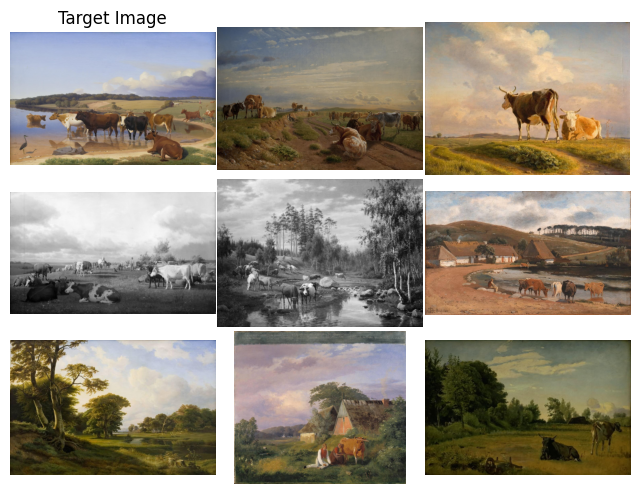

In [97]:
plot_neighbors(feature_list, 80, ds) # choose random image as target image

## Testing 'paper 1' workflow

I'm testing the workflow from paper 1 by constructing some preliminary measures of canonicity. This is mainly to test the workflow on image embeddings

In [ ]:
#smk_canon_variable = []

#for v in df['smk_exhibitions']:
    #if v == True:
     #   smk_canon_variable.append('smk_canon')
   # else:
       # smk_canon_variable.append('non_canon')

#df['canon'] = smk_canon_variable

In [41]:
df['smk_exhibitions'] = df['smk_exhibitions']*1

In [44]:
df['on_display'] = df['on_display']*1

Create variable on whether the artwork has been exhibited anywhere:

In [53]:
def check_exhibitions(exhibitions):
    if isinstance(exhibitions, list):
        return 1 
    else:
        return 0 

In [56]:
exhibitions = [check_exhibitions(exb) for exb in df['exhibitions']]
df['c_exb'] = exhibitions

Create variable on whether the artwork is mentioned in four or more literary works:

In [62]:
len(df['documentation'].iloc[0])

1

In [ ]:
docs_len = []
for docs in df['documentation']:
    try:
        docs_len.append(len(docs))
    
    except:
        docs_len.append(0)
df['docs_len'] = docs_len

In [79]:
docs_canon = [1 if i > 8 else 0 for i in df['docs_len']]
df['docs_canon'] = docs_canon

In [80]:
df['docs_canon'].value_counts()

docs_canon
0    1959
1     126
Name: count, dtype: int64

Add canon "gross-list" if the artwork is in any of the defined canon categories

In [85]:
category = []
for idx, row in df.iterrows():
    if row['docs_canon'] or row['c_exb'] or row['on_display'] == 1:
        category.append('canon')
    else:
        category.append('other')

In [86]:
df['category'] = category

In [87]:
df['category'].value_counts()

category
other    1334
canon     751
Name: count, dtype: int64

### PCA

In [310]:
def plot_pca(ax, data, title, colormapping):
    # Handle embeddings
    embeddings_array = np.array(data["embedding"].to_list(), dtype=np.float32)

    # Make labels titlecase
    colormapping = {k.replace('_', ' ').title(): v for k, v in colormapping.items()}
    # Replace 'o' with 'Other'
    
    # to 2 dimensions
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(embeddings_array)
    
    df_pca = pd.DataFrame(pca_results, columns=["PCA1", "PCA2"])
    
    # Add metadata
    df_pca["canon"] = data["canon"].values
    df_pca["canon"] = df_pca["canon"].apply(lambda x: x.replace('_', ' ').title())
    # replace 'O' with 'Other'
    #df_pca["category"] = df_pca["category"].apply(lambda x: 'Other' if x == 'O' else x)


    # We're gonna set a different alpha for the 'O' category
    #alpha_dict = dict(zip(colormapping.keys(), [0.65 if x != 'Other' else 0.2 for x in colormapping.keys()]))
    # Update color dict to have titlecase

    # Plot each category
    for category in df_pca["canon"].unique():
        subset = df_pca[df_pca["canon"] == category]

        #marker = markers_dict.get(category) 
        #alpha = alpha_dict.get(category)
        
        ax.scatter(
            subset["PCA1"],
            subset["PCA2"],
            color=colormapping.get(category),
            label=category,
            #alpha=alpha,
            edgecolor='black',
            s=110,
            marker='o' #marker
        )

    ax.set_title(title)
    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")

    legend_handles = [Patch(facecolor=color, label=label) for label, color in colormapping.items()]
    ax.legend(handles=legend_handles, loc='upper right')

    ax.axis("equal")

In [93]:
def plot_pca(ax, data, title, colormapping):
    # Handle embeddings
    embeddings_array = np.array(data["embedding"].to_list(), dtype=np.float32)

    # Make labels titlecase
    colormapping = {k.replace('_', ' ').title(): v for k, v in colormapping.items()}
    # Replace 'o' with 'Other'
    
    # to 2 dimensions
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(embeddings_array)
    
    df_pca = pd.DataFrame(pca_results, columns=["PCA1", "PCA2"])
    
    # Add metadata
    df_pca["canon"] = data["canon"].values
    df_pca["canon"] = df_pca["canon"].apply(lambda x: x.replace('_', ' ').title())
    # replace 'O' with 'Other'
    #df_pca["category"] = df_pca["category"].apply(lambda x: 'Other' if x == 'O' else x)


    # We're gonna set a different alpha for the 'O' category
    alpha_dict = dict(zip(colormapping.keys(), [0.65 if x != 'other' else 0.2 for x in colormapping.keys()]))
    # Update color dict to have titlecase

    # Plot each category
    for category in df_pca["canon"].unique():
        subset = df_pca[df_pca["canon"] == category]

        #marker = markers_dict.get(category) 
        alpha = alpha_dict.get(category)
        
        ax.scatter(
            subset["PCA1"],
            subset["PCA2"],
            color=colormapping.get(category),
            label=category,
            alpha=alpha,
            edgecolor='black',
            s=110,
            marker='o' #marker
        )

    ax.set_title(title)
    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")

    legend_handles = [Patch(facecolor=color, label=label) for label, color in colormapping.items()]
    ax.legend(handles=legend_handles, loc='upper right')

    ax.axis("equal")

In [94]:
df.columns

Index(['smk_id', 'period', 'start_year', 'title', 'first_artist',
       'all_artists', 'num_artists', 'main_type', 'all_types',
       'image_thumbnail', 'gender', 'birth_death', 'nationality', 'history',
       'artist_roles', 'creator_roles', 'num_creators', 'techniques',
       'enrichment_url', 'content_person', 'has_text', 'colors',
       'geo_location', 'entropy', 'tags_en', 'image', 'rgb', 'exhibitions',
       'acquisition_date', 'responsible_department', 'documentation',
       'on_display', 'current_location_name', 'literary_reference',
       'object_history_note', 'exhibition_venues', 'smk_exhibitions',
       'embedding', 'c_exb', 'docs_len', 'docs_canon', 'category'],
      dtype='object')

In [ ]:
color_mapping = {'other': '#129525', 'on_display': '#356177', 'smk_exhibitions': '#FE7F2D', 'c_exb': '#9B7496', 'docs_canon': '#75BCC6'}#'#FCCA46'}

In [95]:
subset = df.loc[df['category'] != 'O']

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/

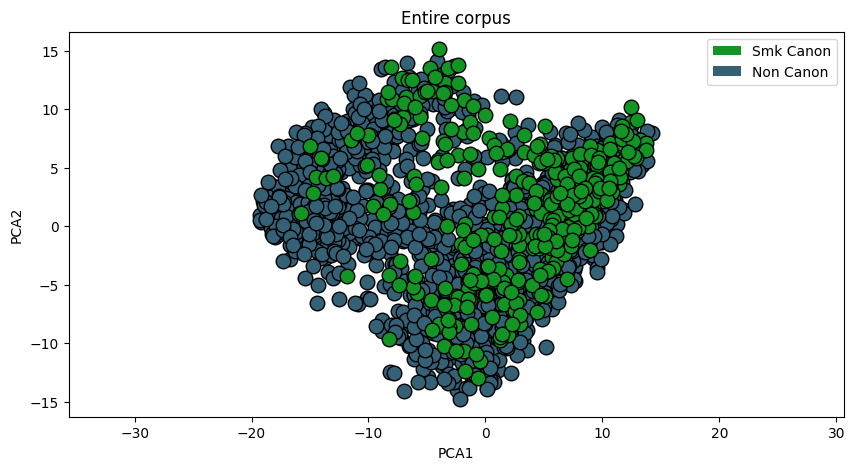

In [311]:
# PCA
# get colors
color_mapping = {'smk_canon': '#129525', 'non_canon': '#356177'}#'#FCCA46'}

fig, axs = plt.subplots(1, 1, figsize=(10, 5))

plot_pca(axs, df, "Entire corpus", color_mapping)

In [ ]:
# PCA 2

### doesn't work with my years, need to do this differently !!! 

# # subsets of the first and last 15 years
sorted_df_year = df.sort_values(by='start_year', ascending=True)
# get the first 419 in a df and the last in another
df_first_15 = sorted_df_year.iloc[:1042]
df_last_15 = sorted_df_year.iloc[1042:]

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/

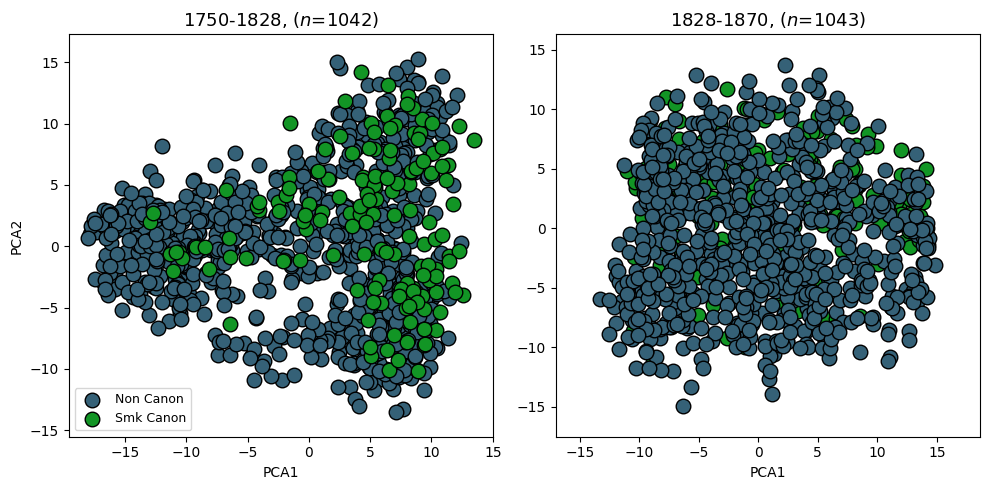

In [326]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Plot PCA for the entire dataset
plot_pca(axs[0], df_first_15, f"{df_first_15['start_year'].min()}-{df_first_15['start_year'].max()}, ($n$={len(df_first_15)})", color_mapping)
# Plot PCA for the subset
plot_pca(axs[1], df_last_15, f"{df_last_15['start_year'].min()}-{df_last_15['start_year'].max()} ($n$={len(df_last_15)})", color_mapping)
# layout
axs[1].legend().remove()
axs[1].set_ylabel("")
axs[0].legend(fontsize=9, loc='lower left')
# # # set x and y lims manually to the same scale
#xlims = [-0.075, 0.1]
#ylims = [-0.1, 0.075]
#axs[0].set_xlim(xlims)
#axs[0].set_ylim(ylims)
#axs[1].set_xlim(xlims)
#axs[1].set_ylim(ylims)
axs[0].set_title(f"{int(df_first_15['start_year'].min())}-{int(df_first_15['start_year'].max())}, ($n$={len(df_first_15)})", fontsize=13)
axs[1].set_title(f"{int(df_last_15['start_year'].min())}-{int(df_last_15['start_year'].max())}, ($n$={len(df_last_15)})", fontsize=13)
plt.tight_layout()
plt.show()

### Measure diachronic change (= variance in embeddings over time)

#### Naive approach (no up or downsampling)

In [328]:
canon_df = df.query("canon == 'smk_canon'")

In [330]:
canon_df

,smk_id,period,start_year,title,first_artist,all_artists,num_artists,main_type,all_types,image_thumbnail,...,documentation,on_display,current_location_name,literary_reference,object_history_note,exhibition_venues,wiki_data,smk_exhibitions,embedding,canon
27,KMS8884,1835,1835,Parti af torvet i Amalfi,Martinus Rørbye,[Martinus Rørbye],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/tt44ps41w_km...,...,<NA>,True,Sal 219,<NA>,<NA>,"[Petit Palais, Sølvgade, Nationalmuseum, Stock...",<NA>,True,"[0.2547459602355957, -0.6865944862365723, 0.94...",smk_canon
29,KMS3880,1800,1800,Jurisprudensen. Allegorisk figur,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/mw22v869s_KM...,...,[{'title': 'Fortegnelse over den danske Samlin...,False,<NA>,<NA>,[På auktion efter Abildgaards enke solgt til J...,"[Louvre, Hamburger Kunsthalle, Sølvgade, Nasjo...",http://www.wikidata.org/entity/Q20440438,True,"[0.722366213798523, -0.381448358297348, -0.525...",smk_canon
30,KMS7591,1800,1800,Filosofien,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/3x816q91r_KM...,...,[{'title': 'Abildgaard=abildgård: kunstneren m...,False,<NA>,<NA>,<NA>,"[Louvre, Hamburger Kunsthalle, Sølvgade, Det K...",http://www.wikidata.org/entity/Q20482222,True,"[0.24958491325378418, -0.5673973560333252, -0....",smk_canon
32,KMS6557,1750,1750,"Romersk kokkedreng, der sliber en kniv",Jean Barbault,[Jean Barbault],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/zw12z8688_KM...,...,[{'title': 'Clinch: danske kunstnere markerer ...,False,<NA>,<NA>,"[Købt 2. maj 1968 af friherre, direktør H.H.M....","[Musée de la Ville de Strasbourg, Sølvgade, Pa...",http://www.wikidata.org/entity/Q20475115,True,"[0.02852189540863037, -0.7672701478004456, -0....",smk_canon
34,KMS852,1865,1865,En såret dansk kriger,Elisabeth Jerichau Baumann,[Elisabeth Jerichau Baumann],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/ks65hg131_KM...,...,[{'title': 'Kunstakademiet 1754-2004: særtryk'...,False,<NA>,<NA>,<NA>,"[Rønnebæksholm, Sølvgade, Nationalmuseum, Stoc...",http://www.wikidata.org/entity/Q20475469,True,"[0.09348553419113159, -0.6381654143333435, -0....",smk_canon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,KMS1139e,1783,1783,Frederik III modtager enevoldsmagten 1660,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/q811kn85p_KM...,...,[{'title': 'Abildgaard=abildgård: kunstneren m...,False,<NA>,<NA>,<NA>,"[Louvre, Hamburger Kunsthalle, Sølvgade, De Ko...",http://www.wikidata.org/entity/Q20441193,True,"[-1.1619858741760254, 0.2300381362438202, -1.3...",smk_canon
2063,KMS596,1785-1786,1785,Potuanernes andagt på festdagen for den ubegri...,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/dn39x487m_KM...,...,[{'title': 'Abildgaard=abildgård: kunstneren m...,True,Sal 217B,"[Motiv fra Ludvig Holberg: ""Niels Klim"", kap. VI]",<NA>,"[Louvre, Hamburger Kunsthalle, Sølvgade, Sølvg...",http://www.wikidata.org/entity/Q20440902,True,"[0.45337992906570435, -1.0508301258087158, 0.4...",smk_canon
2071,KMS4155,1752,1752,Hofjuvelér Christopher Fabritius og hustru Gun...,Peder Als,[Peder Als],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/gb19f975p_KM...,...,"[{'title': 'Ny Carlsbergfondet: 1902-2002', 'a...",True,Sal 217A,<NA>,<NA>,[Sølvgade],http://www.wikidata.org/entity/Q20355193,True,"[0.5485650300979614, -1.9012564420700073, -0.5...",smk_canon
2076,KMS3650,1809,1809,Den græske digter Sappho og mytilenerinden,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/wh246w25z_KM...,...,[{'title': 'Abildgaard=abildgård: kunstneren m...,True,Sal 217B,<NA>,<NA>,"[Louvre, Hamburger Kunsthalle, Sølvgade, Sølvg...",http://www.wikidata.org/entity/Q20540703,True,"[0.8518499135971069, -1.2928787469863892, 0.76...",smk_canon


In [331]:
## Start a loop over the years
mean_similarity_dict = {}

# window size and step size
window_size = 5
step_size = 1

# set sampling
sampling = False
sample_size = 4

# increase if we want to do more runs
number_of_runs = 1

# Get the minimum and maximum years in the dataset
min_year = df['start_year'].min()
max_year = df['start_year'].max()

In [335]:
df['start_year'] = df['start_year'].astype(int)

In [339]:
year_range = range(1800, 1810)
historical = df.loc[(df['start_year'].isin(year_range)) & (df['canon'] != 'smk_canon')]

In [340]:
historical

,smk_id,period,start_year,title,first_artist,all_artists,num_artists,main_type,all_types,image_thumbnail,...,documentation,on_display,current_location_name,literary_reference,object_history_note,exhibition_venues,wiki_data,smk_exhibitions,embedding,canon
0,KKSgb20565,1803-1861,1803,Udsigt fra Rundetårn over København til Freder...,H.G.F. Holm,[H.G.F. Holm],1,Akvarel,"[Akvarel, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/w3763b937_kk...,...,"[{'title': 'Danske tegninger: en oversigt', 'a...",False,<NA>,<NA>,<NA>,"[Metropolitan Museum, New York, The J. Paul Ge...",<NA>,False,"[-0.8619548678398132, -0.13036830723285675, -0...",non_canon
10,KKSgb17268,1800-1899,1800,Flodlandskab med bønder,Wagner,[Wagner],1,Gouache,"[Gouache, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/js956k66d_kk...,...,<NA>,False,<NA>,<NA>,[Johan Conrad Spengler (1767-1839); auktion ef...,<NA>,<NA>,False,"[1.2326291799545288, -1.5515855550765991, -0.2...",non_canon
14,KKSgb17334,1801,1801,Slaget på Reden,Gustaf Boberg,[Gustaf Boberg],1,Akvarel,"[Akvarel, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/bn999b76s_kk...,...,<NA>,False,<NA>,<NA>,<NA>,<NA>,<NA>,False,"[0.7025460004806519, 0.13684678077697754, -1.0...",non_canon
18,KKS10132,1800-1849,1800,Ærkeengelen Michael ved Helvedes Port med svær...,Ubekendt,[Ubekendt],1,Akvarel,"[Akvarel, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/76537366h_kk...,...,[{'title': 'Les marques de collections de dess...,False,<NA>,<NA>,[Dekan Veith; auktion over dennes samling hos ...,<NA>,<NA>,False,"[0.3571798801422119, 0.6492969989776611, 0.916...",non_canon
86,KMS274,1809,1809,Dannebrog falder ned fra himlen under Volmersl...,C.A. Lorentzen,[C.A. Lorentzen],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/3x816q875_KM...,...,[{'title': 'Kritiske bidrag til nyere dansk tæ...,True,Sal 218A,[Motivet har maleren fundet i Holbergs Danmark...,[Købt på Salonen på Charlottenborg i 1815 (kat...,"[Kadriorg Art Museum / Art Museum of Estonia, ...",http://www.wikidata.org/entity/Q20355266,False,"[0.1639196276664734, -0.3694455623626709, 0.02...",non_canon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2048,KMS3342,1809,1809,Apollon pålægger Parcerne at opsøge den fra jo...,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/f4752m074_KM...,...,[{'title': 'Abildgaard=abildgård: kunstneren m...,False,<NA>,<NA>,<NA>,<NA>,http://www.wikidata.org/entity/Q20268387,False,"[0.5110499858856201, -1.8844141960144043, 0.75...",non_canon
2055,KMS2069,1807-1811,1807,Skuespillerinden Johanne Cathrine Rosing,C.W. Eckersberg,[C.W. Eckersberg],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/2z10wv69p_km...,...,<NA>,False,<NA>,<NA>,<NA>,<NA>,http://www.wikidata.org/entity/Q20355570,False,"[0.42504650354385376, -0.6999711394309998, -0....",non_canon
2069,KMS3723,1803-1809,1803,Julia og Fulvia,Ubekendt,[Ubekendt],1,Maleri,[Maleri],https://api.smk.dk/api/v1/thumbnail/2773ba01-b...,...,<NA>,False,<NA>,"[Scene fra Voltaire: ""Le Triumvirat"", IV. akt]",<NA>,<NA>,http://www.wikidata.org/entity/Q20429131,False,"[0.8006978034973145, -1.0328679084777832, 1.17...",non_canon
2077,KMS3240,1807-1808,1807,"Tjenestepigen Fotis forfærdes over, at heksesa...",Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://api.smk.dk/api/v1/thumbnail/7f067f8c-8...,...,[{'title': 'Abildgaard=abildgård: kunstneren m...,False,<NA>,"[Apulejus: Det Gyldne æsel, 3. bog, kap. 24-25]",<NA>,<NA>,http://www.wikidata.org/entity/Q20392386,False,"[0.5023291110992432, -1.3812183141708374, 0.44...",non_canon


In [344]:
from sklearn.metrics.pairwise import cosine_similarity

In [345]:
def get_cosim_mean_std(key):
    data = group_eb[key]
    embeddings = np.stack(data['embedding'].values)
    mean_cosim = cosine_similarity(embeddings).mean()
    std_cosim = cosine_similarity(embeddings).std()
    
    return mean_cosim, std_cosim

In [364]:
for start_year in range(min_year, max_year - window_size + 1, step_size):

    temp = {}

    # Define rolling window range for each window
    year_range = list(range(start_year, start_year + window_size))
    range_label = f"{year_range[0]}-{year_range[-1]}"

    canon = df.loc[(df['start_year'].isin(year_range)) & (df['canon'] == 'smk_canon')]
    non_canon = df.loc[(df['start_year'].isin(year_range)) & (df['canon'] != 'smk_canon')]

    df_total = df.loc[df['start_year'].isin(year_range)]

    group_eb = {'canon': canon, 'non_canon': non_canon, 'df_total': df_total}

    if sampling == True:
    # sample from the groups

        for key in group_eb:
            group = group_eb[key]
            group_eb[key] = group.sample(sample_size, random_state=run) if len(group) > sample_size else group
    
    
    # get the mean embeddings of the current window for each group
    canon_mean = group_eb['canon']['embedding'].mean(axis=0)
    non_canon_mean = group_eb['non_canon']['embedding'].mean(axis=0)

    # get the cosine similarity btw canon and non-canon
    canon_noncanon_similarity = cosine_similarity(np.stack([non_canon_mean, canon_mean])).mean()
    temp['CANON_NONCANON_COSIM'] = canon_noncanon_similarity

    # save
    #mean_similarity_dict[range_label] = temp

    # get canon embeddings
    canon_mean, canon_std = get_cosim_mean_std('canon')
    temp['CANON_COSIM_MEAN'] = canon_mean 
    temp['CANON_COSIM_STD'] = canon_std

    nc_mean, nc_std = get_cosim_mean_std('non_canon')
    temp['NONCANON_COSIM_MEAN'] = nc_mean
    temp['NONCANON_COSIM_STD'] = nc_std

    t_mean, t_std = get_cosim_mean_std('df_total')
    temp['TOTAL_COSIM_MEAN'] = t_mean
    temp['TOTAL_COSIM_STD'] = t_std

    temp['n_paintings'] = [len(df_total), len(canon), len(non_canon)]
    mean_similarity_dict[range_label] = temp

# Format df
sim_df = pd.DataFrame.from_dict(mean_similarity_dict, orient='index').reset_index()
sim_df = sim_df.rename(columns={"index": "year_RANGE"})

sim_df['START_year'] = sim_df['year_RANGE'].apply(lambda x: int(x.split('-')[0]))
    

    #windows_list.append(temp)


/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203:

In [365]:
sim_df

,year_RANGE,CANON_NONCANON_COSIM,CANON_COSIM_MEAN,CANON_COSIM_STD,NONCANON_COSIM_MEAN,NONCANON_COSIM_STD,TOTAL_COSIM_MEAN,TOTAL_COSIM_STD,n_paintings,START_year
0,1750-1754,0.910108,0.626348,0.184880,0.460236,0.159538,0.458183,0.155983,"[64, 6, 58]",1750
1,1751-1755,0.912021,0.673460,0.211620,0.461158,0.157368,0.461952,0.156251,"[51, 4, 47]",1751
2,1752-1756,0.924234,0.617096,0.223055,0.486692,0.154007,0.484809,0.151123,"[73, 4, 69]",1752
3,1753-1757,0.904733,0.630847,0.223716,0.483345,0.155262,0.480055,0.151654,"[70, 4, 66]",1753
4,1754-1758,0.910898,0.585042,0.265036,0.516609,0.157614,0.509268,0.154233,"[63, 4, 59]",1754
...,...,...,...,...,...,...,...,...,...,...
111,1861-1865,0.915081,0.593755,0.199270,0.455148,0.137166,0.452188,0.131922,"[53, 6, 47]",1861
112,1862-1866,0.897741,0.612501,0.209925,0.457326,0.131150,0.452711,0.128393,"[56, 5, 51]",1862
113,1863-1867,0.886263,0.550695,0.225149,0.470176,0.132198,0.456687,0.130066,"[58, 6, 52]",1863
114,1864-1868,0.927470,0.515865,0.227144,0.443098,0.124763,0.438097,0.121844,"[68, 6, 62]",1864


Text(0.5, 1.0, 'Canon vs Non-Canon Cosine Similarity Over Time')

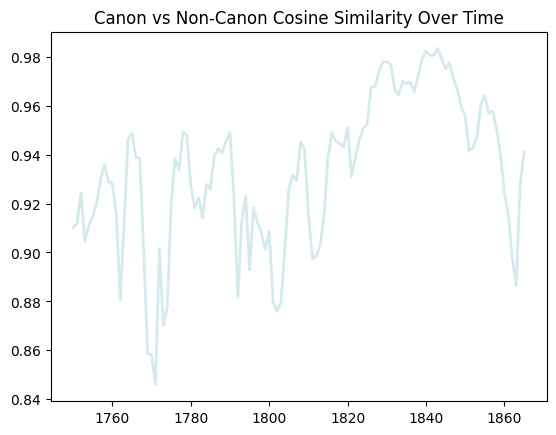

In [374]:
plt.plot(sim_df['START_year'], sim_df['CANON_NONCANON_COSIM'], color='#75BCC6', linewidth=2, 
             alpha=0.3)
plt.title("Canon vs Non-Canon Cosine Similarity Over Time")

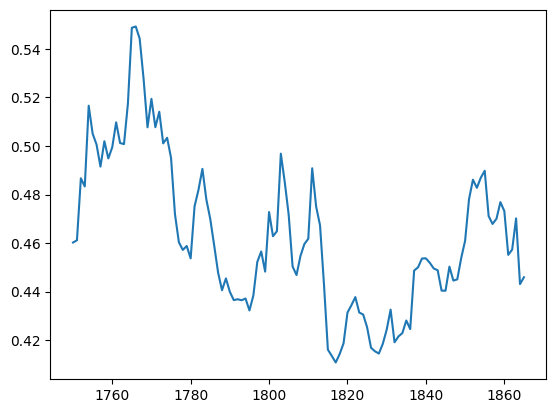

In [368]:
plt.plot(sim_df['START_year'], sim_df['NONCANON_COSIM_MEAN'])

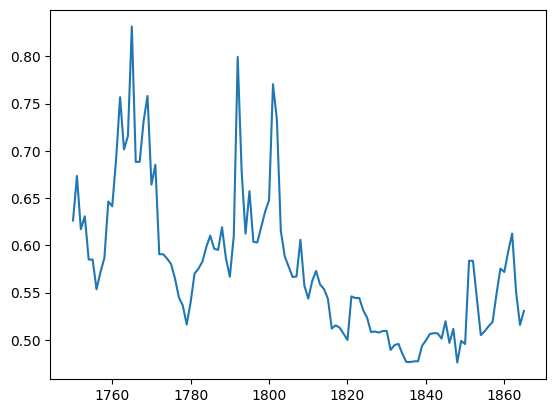

In [369]:
plt.plot(sim_df['START_year'], sim_df['CANON_COSIM_MEAN'])

In [353]:
df.query('smk_exhibitions == True')

,smk_id,period,start_year,title,first_artist,all_artists,num_artists,main_type,all_types,image_thumbnail,...,documentation,on_display,current_location_name,literary_reference,object_history_note,exhibition_venues,wiki_data,smk_exhibitions,embedding,canon
27,KMS8884,1835,1835,Parti af torvet i Amalfi,Martinus Rørbye,[Martinus Rørbye],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/tt44ps41w_km...,...,<NA>,True,Sal 219,<NA>,<NA>,"[Petit Palais, Sølvgade, Nationalmuseum, Stock...",<NA>,True,"[0.2547459602355957, -0.6865944862365723, 0.94...",smk_canon
29,KMS3880,1800,1800,Jurisprudensen. Allegorisk figur,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/mw22v869s_KM...,...,[{'title': 'Fortegnelse over den danske Samlin...,False,<NA>,<NA>,[På auktion efter Abildgaards enke solgt til J...,"[Louvre, Hamburger Kunsthalle, Sølvgade, Nasjo...",http://www.wikidata.org/entity/Q20440438,True,"[0.722366213798523, -0.381448358297348, -0.525...",smk_canon
30,KMS7591,1800,1800,Filosofien,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/3x816q91r_KM...,...,[{'title': 'Abildgaard=abildgård: kunstneren m...,False,<NA>,<NA>,<NA>,"[Louvre, Hamburger Kunsthalle, Sølvgade, Det K...",http://www.wikidata.org/entity/Q20482222,True,"[0.24958491325378418, -0.5673973560333252, -0....",smk_canon
32,KMS6557,1750,1750,"Romersk kokkedreng, der sliber en kniv",Jean Barbault,[Jean Barbault],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/zw12z8688_KM...,...,[{'title': 'Clinch: danske kunstnere markerer ...,False,<NA>,<NA>,"[Købt 2. maj 1968 af friherre, direktør H.H.M....","[Musée de la Ville de Strasbourg, Sølvgade, Pa...",http://www.wikidata.org/entity/Q20475115,True,"[0.02852189540863037, -0.7672701478004456, -0....",smk_canon
34,KMS852,1865,1865,En såret dansk kriger,Elisabeth Jerichau Baumann,[Elisabeth Jerichau Baumann],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/ks65hg131_KM...,...,[{'title': 'Kunstakademiet 1754-2004: særtryk'...,False,<NA>,<NA>,<NA>,"[Rønnebæksholm, Sølvgade, Nationalmuseum, Stoc...",http://www.wikidata.org/entity/Q20475469,True,"[0.09348553419113159, -0.6381654143333435, -0....",smk_canon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,KMS1139e,1783,1783,Frederik III modtager enevoldsmagten 1660,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/q811kn85p_KM...,...,[{'title': 'Abildgaard=abildgård: kunstneren m...,False,<NA>,<NA>,<NA>,"[Louvre, Hamburger Kunsthalle, Sølvgade, De Ko...",http://www.wikidata.org/entity/Q20441193,True,"[-1.1619858741760254, 0.2300381362438202, -1.3...",smk_canon
2063,KMS596,1785-1786,1785,Potuanernes andagt på festdagen for den ubegri...,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/dn39x487m_KM...,...,[{'title': 'Abildgaard=abildgård: kunstneren m...,True,Sal 217B,"[Motiv fra Ludvig Holberg: ""Niels Klim"", kap. VI]",<NA>,"[Louvre, Hamburger Kunsthalle, Sølvgade, Sølvg...",http://www.wikidata.org/entity/Q20440902,True,"[0.45337992906570435, -1.0508301258087158, 0.4...",smk_canon
2071,KMS4155,1752,1752,Hofjuvelér Christopher Fabritius og hustru Gun...,Peder Als,[Peder Als],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/gb19f975p_KM...,...,"[{'title': 'Ny Carlsbergfondet: 1902-2002', 'a...",True,Sal 217A,<NA>,<NA>,[Sølvgade],http://www.wikidata.org/entity/Q20355193,True,"[0.5485650300979614, -1.9012564420700073, -0.5...",smk_canon
2076,KMS3650,1809,1809,Den græske digter Sappho og mytilenerinden,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/wh246w25z_KM...,...,[{'title': 'Abildgaard=abildgård: kunstneren m...,True,Sal 217B,<NA>,<NA>,"[Louvre, Hamburger Kunsthalle, Sølvgade, Sølvg...",http://www.wikidata.org/entity/Q20540703,True,"[0.8518499135971069, -1.2928787469863892, 0.76...",smk_canon


#### Inter-group similarity

we want to see if the difference btw canon and noncanon decreases over time